In [144]:
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score #evaluates how good clustering is
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn import metrics
import scipy.stats as stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler


#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.tree import export_graphviz

/Users/207889/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [112]:
#Load Data
restdata = pd.read_csv('Restaurant_Inspections.csv')

In [113]:
restdatacleaned = restdata.copy()
#Replace spaces with _ in column names
restdatacleaned.columns = restdata.columns.map(lambda x: x.replace(" ","_"))

#clean up column names by lowercasing them
restdatacleaned.columns = restdatacleaned.columns.str.lower()

In [114]:
restdatacleaned.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type
0,40393378,E.J LUNCHEONETTE,MANHATTAN,1271,THIRD AVENUE,10021,2124720600,American,07/12/2016,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,31.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
1,41030615,SERAFINA,MANHATTAN,210,WEST 55 STREET,10019,2123151700,Italian,03/18/2016,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,4.0,A,03/18/2016,04/22/2017,Cycle Inspection / Initial Inspection
2,40871795,WONDEE SIAM II,MANHATTAN,813,9 AVENUE,10019,9172861726,Thai,12/23/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,29.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
3,40750612,STROKOS PIZZA DELI,MANHATTAN,888,10 AVENUE,10019,2125816262,American,09/20/2016,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,13.0,A,09/20/2016,04/22/2017,Cycle Inspection / Initial Inspection
4,50036944,AMBER,MANHATTAN,103,W 70TH ST,10023,2127998100,Asian,11/12/2015,Violations were cited in the following area(s).,09B,Thawing procedures improper.,Not Critical,9.0,A,11/12/2015,04/22/2017,Pre-permit (Operational) / Re-inspection


In [115]:
#Investigate Data types
restdatacleaned.dtypes

camis                      int64
dba                       object
boro                      object
building                  object
street                    object
zipcode                    int64
phone                     object
cuisine_description       object
inspection_date           object
action                    object
violation_code            object
violation_description     object
critical_flag             object
score                    float64
grade                     object
grade_date                object
record_date               object
inspection_type           object
dtype: object

In [116]:
#Drop columns that don't add to analysis
restdatacleaned = restdatacleaned.drop(['camis','dba','inspection_date','building','street','phone','zipcode','action','violation_description','grade_date','record_date','inspection_type','grade'], axis=1)

In [117]:
#Drop all na values
restdatacleaned = restdatacleaned.dropna()

print "the original dataset size:", restdata.shape
print "after we dropped na values:", restdatacleaned.shape

#Calculate % of dataset lost

the original dataset size: (27251, 18)
after we dropped na values: (25526, 5)


In [118]:
#convert score column to integer
restdatacleaned.score = restdatacleaned.score.astype(int)

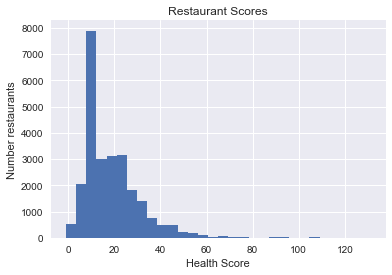

In [82]:
#Examine distribution of health scores
restdatacleaned.score.hist(bins=30)
sns.plt.title("Restaurant Scores")
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")



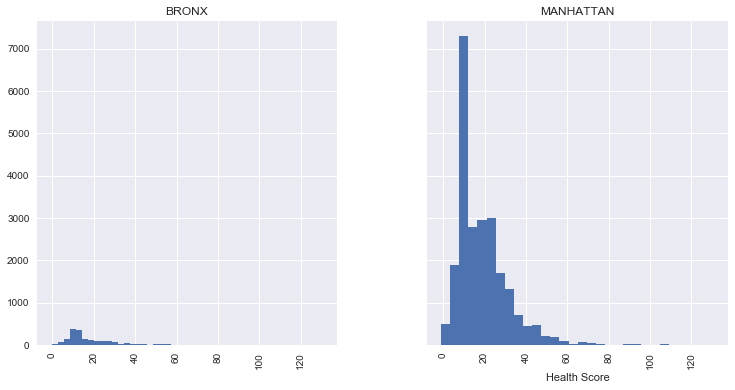

In [21]:
#Examine distribution by boro
#Notice that Bronx and Manhattan are only boroughs represented in this dataset

restdatacleaned.hist(by=restdatacleaned["boro"],bins=30,layout= (1,2),figsize=(12,6),sharex=True,sharey=True)
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")

In [119]:
#There are 62 different cuisines. To simplify dataset, we are going to examine the cuisines that make up 80% of the dataset
#Top 17

#Replace stange formatting for cafe

restdatacleaned.cuisine_description.replace(regex=True,inplace=True,to_replace='CafÃ©/Coffee/Tea',value='Cafe, Coffee, Tea')
restdatacleaned.cuisine_description.value_counts()

restdatacuisinefilter = restdatacleaned.cuisine_description.value_counts(dropna=False)[1:18].index.values.tolist()

restdatafilter = restdatacleaned[restdatacleaned['cuisine_description'].isin(restdatacuisinefilter)]
restdatafilter.cuisine_description.value_counts()

Italian                                                             1976
Chinese                                                             1478
Japanese                                                            1422
Cafe, Coffee, Tea                                                   1209
Pizza                                                                959
Mexican                                                              882
French                                                               769
Indian                                                               740
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     552
Thai                                                                 547
Delicatessen                                                         484
Pizza/Italian                                                        463
Asian                                                                421
Bakery                                             

In [120]:
print "the filtered dataset size is", 
restdatafilter.shape

the filtered dataset size is

(13424, 5)

In [121]:
#drop letter character from violation_code to convert to a number to use in model
restdatafilter['violation_code'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

#convert violation_code column to integer
restdatafilter.violation_code = restdatafilter.violation_code.astype(int)

#Take a look at most common violation_code
restdatafilter.violation_code.value_counts(dropna=False)

10    3341
4     2922
6     2855
2     2146
8     1584
9      365
5      175
3       23
22      10
7        2
16       1
Name: violation_code, dtype: int64

In [122]:
#Convert critical flag to score
criticalflag_dummies = pd.get_dummies(restdatafilter.critical_flag).astype(int)
criticalflag_dummies.head()

restdatafilter = pd.concat([restdatafilter,criticalflag_dummies],axis=1)
restdatafilter.drop("critical_flag",inplace=True,axis=1)
restdatafilter.head()

,boro,cuisine_description,violation_code,score,Critical,Not Applicable,Not Critical
1,MANHATTAN,Italian,9,4,0,0,1
2,MANHATTAN,Thai,2,29,1,0,0
4,MANHATTAN,Asian,9,9,0,0,1
5,MANHATTAN,Thai,8,22,0,0,1
8,MANHATTAN,Japanese,10,32,0,0,1


In [123]:
#get_dummies for cuisine

cuisinedummies = pd.get_dummies(restdatafilter.cuisine_description).astype(int)
cuisinedummies.head()

restdatafilter = pd.concat([restdatafilter,cuisinedummies],axis=1)
restdatafilter.drop("cuisine_description",inplace=True,axis=1)
restdatafilter.head()

,boro,violation_code,score,Critical,Not Applicable,Not Critical,Asian,Bakery,"Cafe, Coffee, Tea",Chinese,...,Irish,Italian,Japanese,Jewish/Kosher,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai
1,MANHATTAN,9,4,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,MANHATTAN,2,29,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,MANHATTAN,9,9,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,MANHATTAN,8,22,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,MANHATTAN,10,32,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [124]:
#Get dummies for boro

borodummies = pd.get_dummies(restdatafilter.boro).astype(int)

restdatafilter = pd.concat([restdatafilter,borodummies],axis=1)
restdatafilter.drop("boro",inplace=True,axis=1)

In [125]:
restdatafilter.dtypes

violation_code                                                      int64
score                                                               int64
Critical                                                            int64
Not Applicable                                                      int64
Not Critical                                                        int64
Asian                                                               int64
Bakery                                                              int64
Cafe, Coffee, Tea                                                   int64
Chinese                                                             int64
Delicatessen                                                        int64
French                                                              int64
Indian                                                              int64
Irish                                                               int64
Italian                               

In [126]:
restdatafilter.dtypes

violation_code                                                      int64
score                                                               int64
Critical                                                            int64
Not Applicable                                                      int64
Not Critical                                                        int64
Asian                                                               int64
Bakery                                                              int64
Cafe, Coffee, Tea                                                   int64
Chinese                                                             int64
Delicatessen                                                        int64
French                                                              int64
Indian                                                              int64
Irish                                                               int64
Italian                               

In [127]:
#Move score to last column and group feature columns

restdata_cols = restdatafilter.columns.tolist()

restdata_cols[0:1]+restdata_cols[22:24]+restdata_cols[2:22]+restdata_cols[1:2]

restdata_colsselect = restdata_cols[0:1]+restdata_cols[22:24]+restdata_cols[2:22]+restdata_cols[1:2]
restdata_colsselect

restdatafilter = restdatafilter[restdata_colsselect]

restdatafilter.head()

,violation_code,BRONX,MANHATTAN,Critical,Not Applicable,Not Critical,Asian,Bakery,"Cafe, Coffee, Tea",Chinese,...,Italian,Japanese,Jewish/Kosher,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai,score
1,9,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4
2,2,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,29
4,9,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5,8,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,22
8,10,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,32


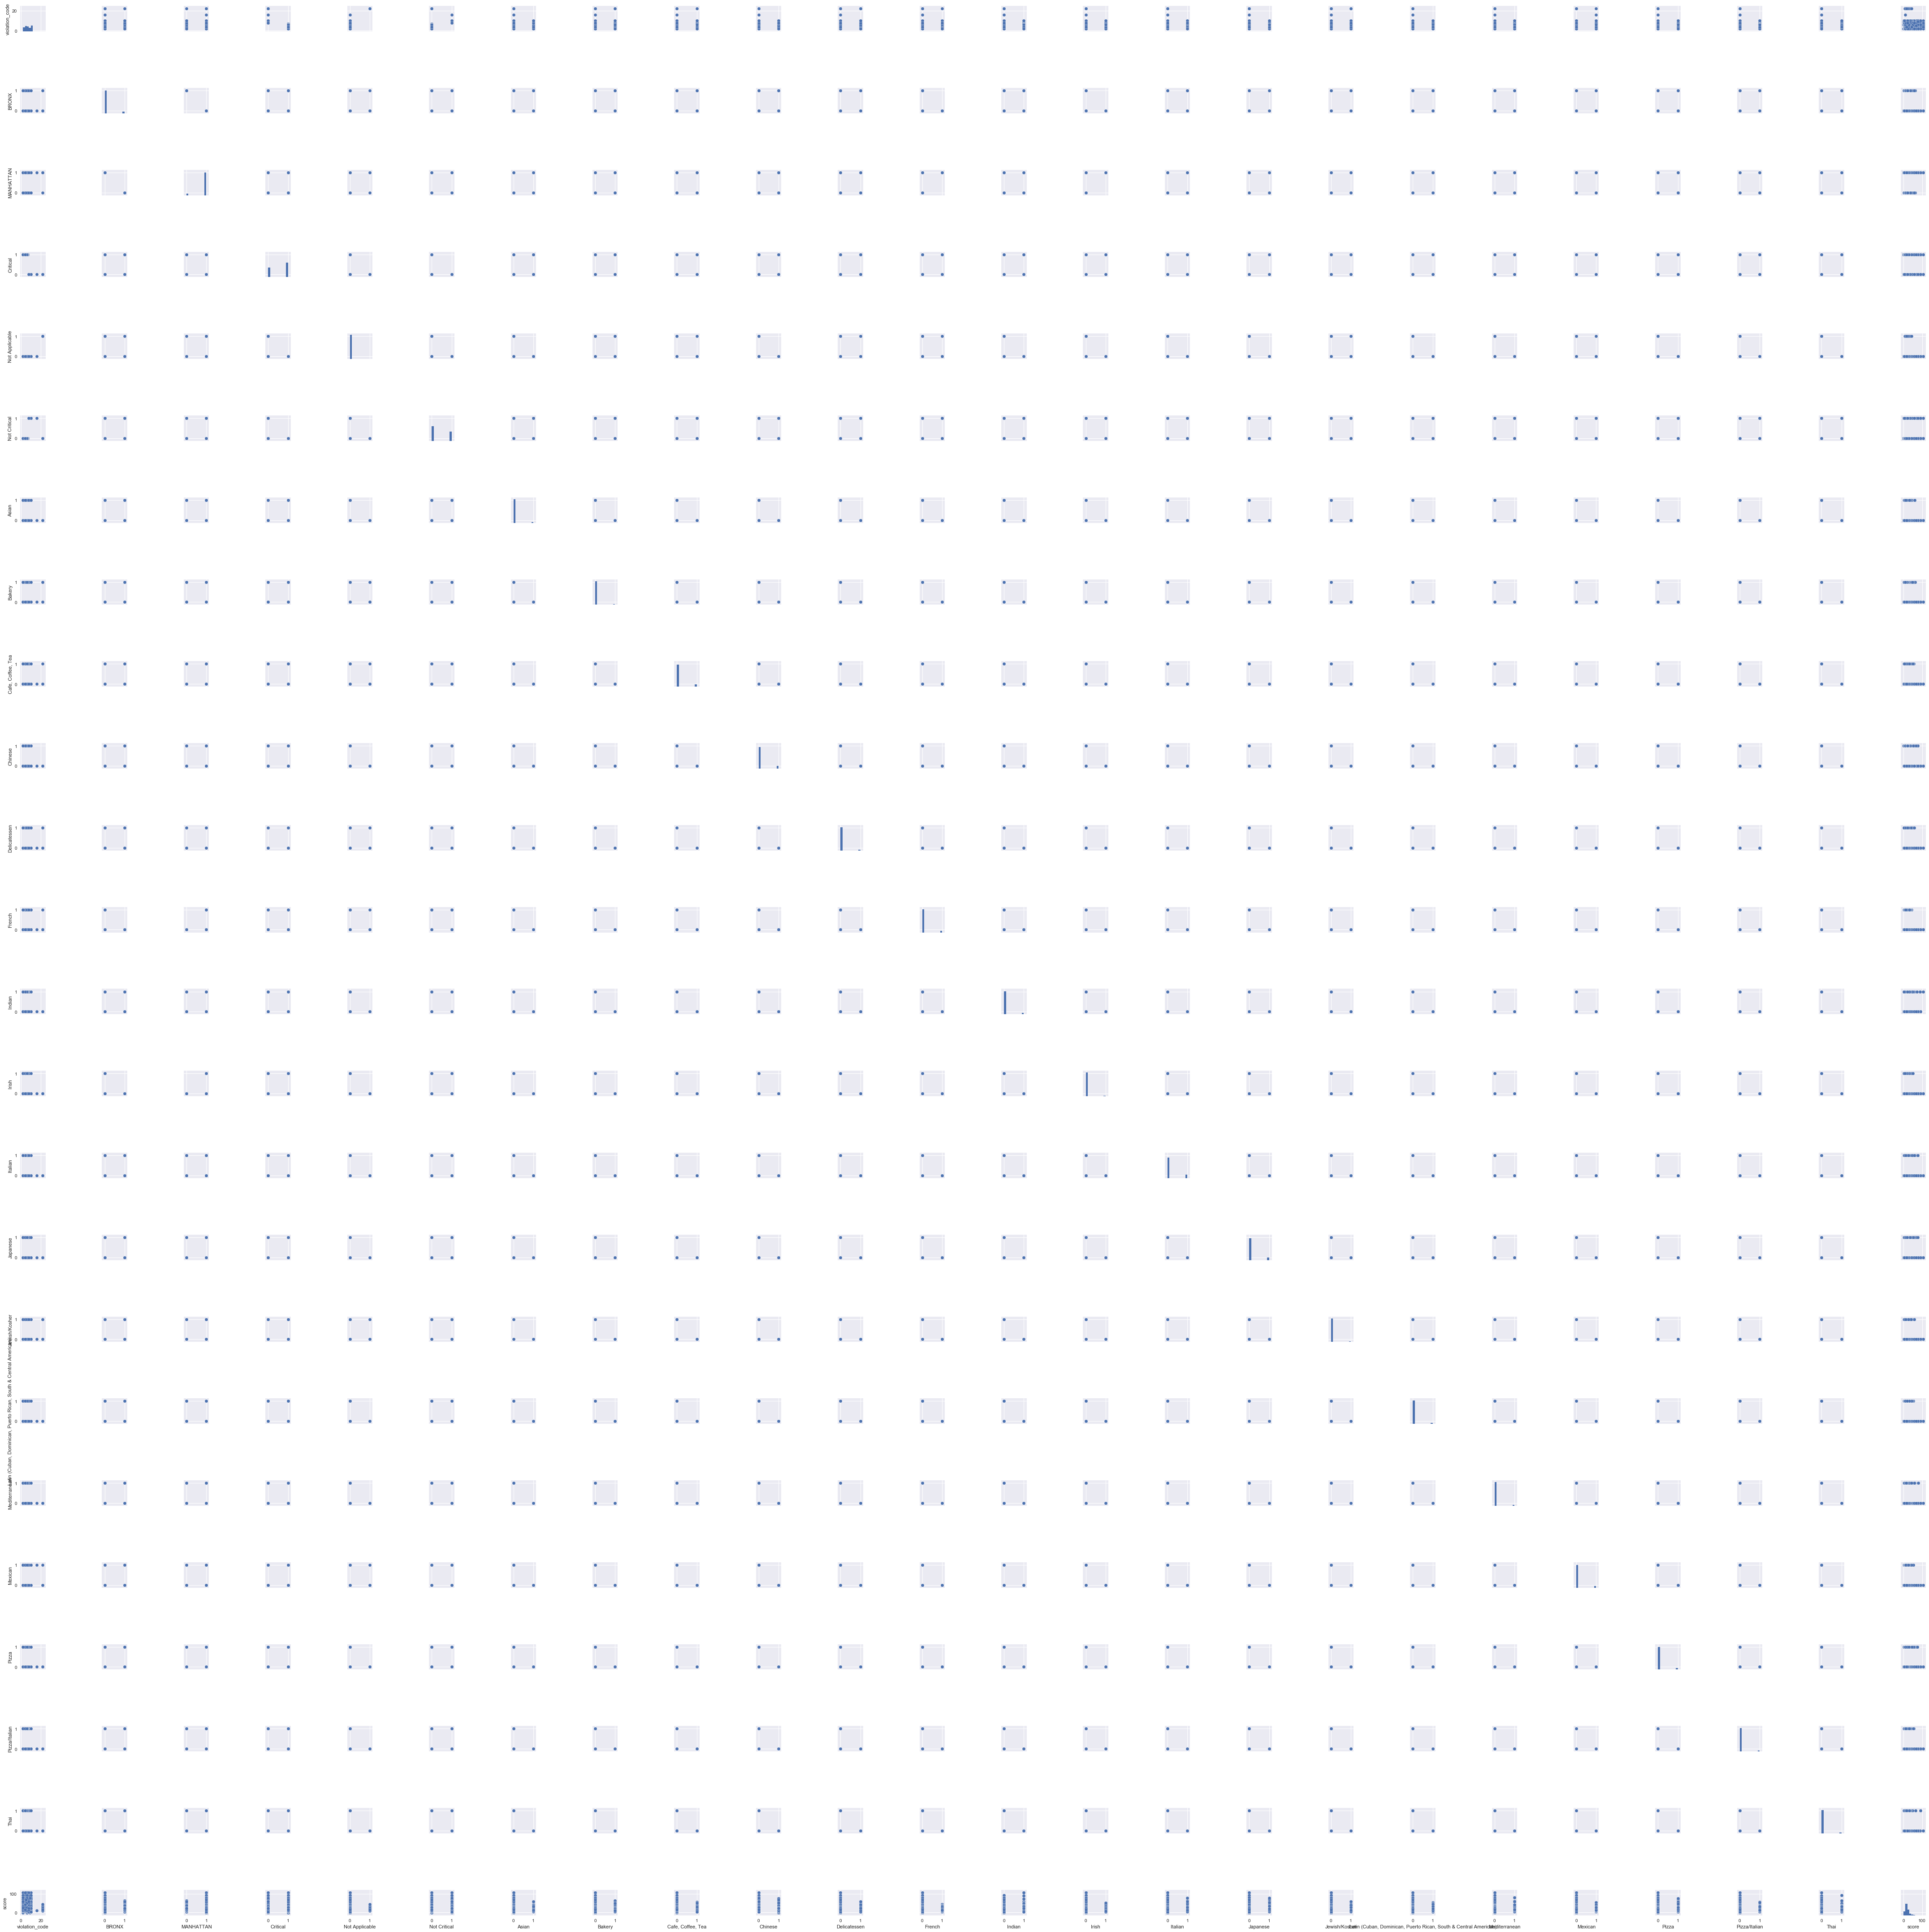

In [102]:
sns.pairplot(restdatafilter)


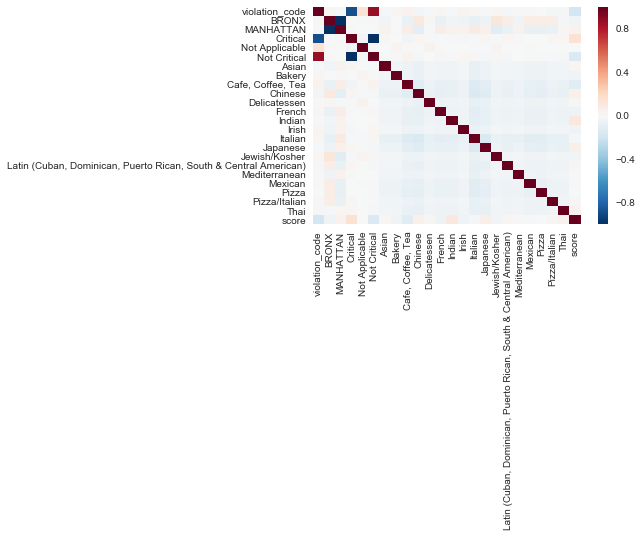

In [128]:
restcorr = restdatafilter.corr()
sns.heatmap(restcorr)

In [135]:
#Isolate feature and target columns

rest_features = restdatafilter.columns.tolist()[0:-1]
rest_features_cols = restdatafilter[rest_features]
rest_features_cols

rest_target = restdatafilter.columns.tolist()[-1]
rest_target_col = restdatafilter[rest_target]

In [131]:
scaler = StandardScaler() #create a scaler object
scaler.fit(rest_features_cols) #fit the scaler
X_scaled = scaler.transform(rest_features_cols) #transform the data with it

In [140]:
y = rest_target_col

In [155]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.4,
                                                 random_state=20)

Decision Tree Train/Test RMSE: 12.0069757378   12.8655940717
Decision Tree Train/Test RMSE: 11.917326531   12.812084993
Decision Tree Train/Test RMSE: 11.8395584087   12.7539550756
Decision Tree Train/Test RMSE: 11.7766931574   12.7024645795
Decision Tree Train/Test RMSE: 11.7289146835   12.6959887283
Decision Tree Train/Test RMSE: 11.6666819386   12.6760698552
Decision Tree Train/Test RMSE: 11.6292801588   12.64329311
Decision Tree Train/Test RMSE: 11.603637367   12.6150562865
Decision Tree Train/Test RMSE: 11.5794156857   12.5927697518
Decision Tree Train/Test RMSE: 11.5583217261   12.5832201696
Decision Tree Train/Test RMSE: 11.5478224648   12.584175833
Decision Tree Train/Test RMSE: 11.5344247185   12.5974939979
Decision Tree Train/Test RMSE: 11.527416645   12.6012122233
Decision Tree Train/Test RMSE: 11.520857624   12.608957261
Decision Tree Train/Test RMSE: 11.5139738095   12.6224108224
Decision Tree Train/Test RMSE: 11.505673584   12.6337819963
Decision Tree Train/Test RMSE: 11.

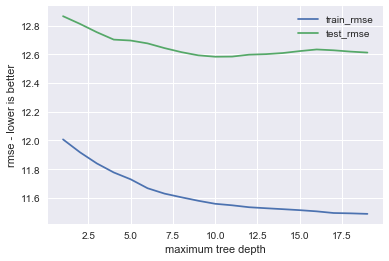

In [162]:
depths = range(1,20)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print "Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.plt.plot(depths,train_rmse,label='train_rmse')
sns.plt.plot(depths,test_rmse,label='test_rmse')
sns.plt.xlabel("maximum tree depth")
sns.plt.ylabel("rmse - lower is better")
sns.plt.legend()

In [168]:
decision_tree_10 = DecisionTreeRegressor(max_depth=10)
decision_tree_10.fit(X_train,y_train)
print "Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test,decision_tree.predict(X_test)))

Decision Tree RMSE: 12.5832201696


In [169]:
# compute feature importances
pd.DataFrame({'feature':rest_features_cols, 
              'importance':decision_tree_10.feature_importances_}).sort_values(by='importance',ascending=False)

ValueError: cannot copy sequence with size 23 to array axis with dimension 13424

In [148]:
rf = RandomForestClassifier(n_estimators=50)
#compute cross-validation score accuracy across 4 folds
cross_val_scores = cross_val_score(rf,X_scaled,y,cv=4)
print "10-fold accuracies:\n",cross_val_scores
print "Mean cv-accuracy:",np.mean(cross_val_scores)
print "Std of cv-accuracy:",np.std(cross_val_scores)

10-fold accuracies:
[ 0.09908311  0.09985141  0.09291903  0.09936956]
Mean cv-accuracy: 0.0978057784388
Std of cv-accuracy: 0.00283469109826


In [ ]:
linreg = LinearRegression()
linreg.fit(X, y)
outcome_pred = linreg.predict(X)

In [136]:
#standardize the features, to get actual interpretable coefficients for each feature
X = StandardScaler().fit_transform(restdatafilter[rest_features_cols])
y = restdatafilter[rest_target]


ValueError: Must pass DataFrame with boolean values only

In [132]:
X_scaled

array([[ 0.96047143, -0.27204029,  0.27204029, ..., -0.27737235,
        -0.18900411, -0.20610395],
       [-1.46929246, -0.27204029,  0.27204029, ..., -0.27737235,
        -0.18900411,  4.85192059],
       [ 0.96047143, -0.27204029,  0.27204029, ..., -0.27737235,
        -0.18900411, -0.20610395],
       ..., 
       [ 1.30758056,  3.67592606, -3.67592606, ..., -0.27737235,
        -0.18900411, -0.20610395],
       [ 0.61336231, -0.27204029,  0.27204029, ..., -0.27737235,
        -0.18900411, -0.20610395],
       [-0.7750742 , -0.27204029,  0.27204029, ..., -0.27737235,
        -0.18900411,  4.85192059]])

In [213]:
restdatacuisine = restdatacleaned.merge(cusineDF,left_index=True,right_index=True

In [ ]:
#Convert critical to flag
#Convert boros to columns
#Convert cuisines to columns
#Use decsion trees or random forrest